Optimal I1: 10.00 bits
Optimal I2: 10.00 bits


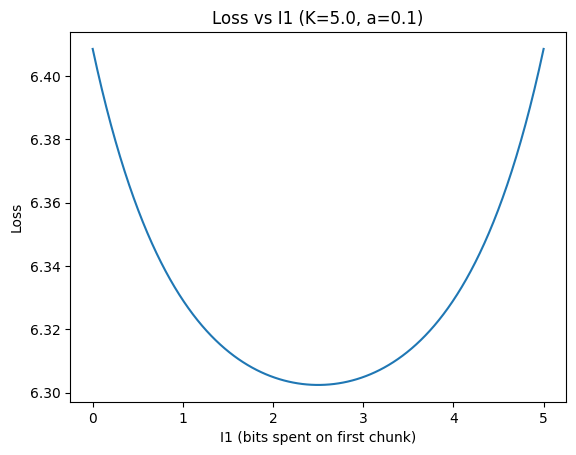

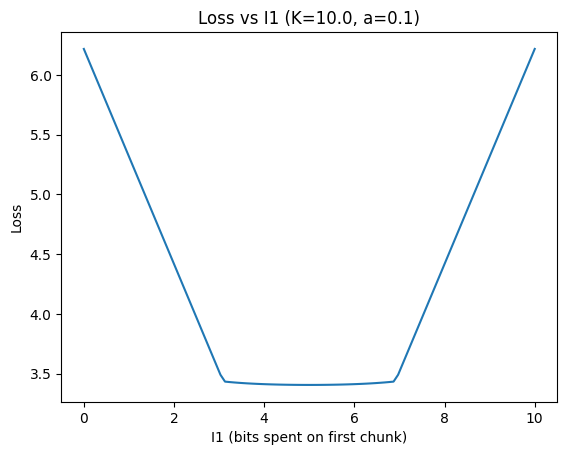

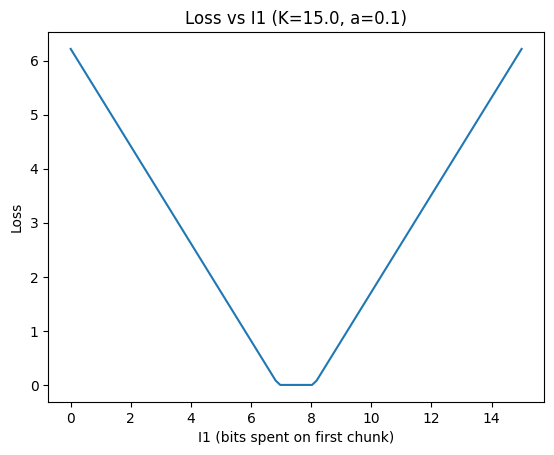

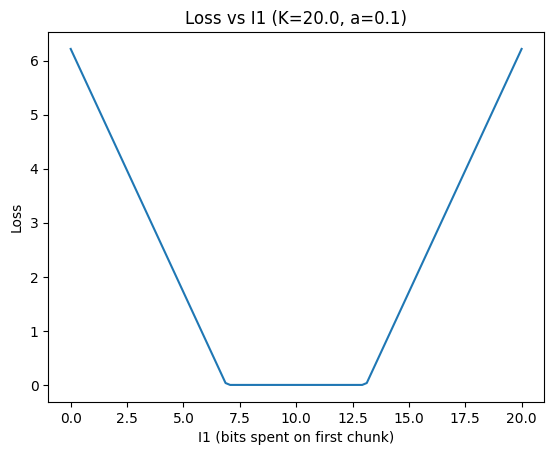

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from transformer_reasoning.evaluation.measure_entropy import calculate_entropy
from transformer_reasoning.evaluation.measure_capacity import calculate_capacities_per_attr
from transformer_reasoning.generate_dataset.generate_profiles import RELATIONSHIP_TYPES

def neg_log_likelihood(I, a, N, r=16):
    """
    I[0] = I_1 (bits spent on first chunk)
    I[1] = I_2 (bits spent on second chunk)
    a = fraction of one-hop questions
    N = vocab size
    r = number of relations
    """
    logN = np.log(N)
    
    # Convert I to probabilities
    p1 = np.exp(-(max(0, logN - I[0])))
    p2 = np.exp(-(max(0, logN - I[1])))
    
    # One hop loss
    loss_1hop = max(0, logN - I[0] - I[1])

    p_2hop = p1 * p2 + (1-p1)*(1-p2)/(N)
    loss_2hop = -np.log(p_2hop)
    
    return a*loss_1hop + (1-a)*loss_2hop

def constraint(I, K):
    return I[0] + I[1] - K

# Example parameters
N = 1000  # vocab size
K = 20     # bit budget
a = 0.1   # fraction of one-hop questions

# Optimize
bounds = [(0, K), (0, K)]
constraint_dict = {'type': 'eq', 'fun': lambda I: constraint(I, K)}
result = minimize(lambda I: neg_log_likelihood(I, a, N, K), 
                 x0=[K/2, K/2],
                 bounds=bounds,
                 constraints=constraint_dict)

print(f"Optimal I1: {result.x[0]:.2f} bits")
print(f"Optimal I2: {result.x[1]:.2f} bits")

for K in np.linspace(5, 20, 4):

    # Plot loss landscape
    I1_range = np.linspace(0, K, 100)
    I2_range = K - I1_range
    losses = [neg_log_likelihood([i1, i2], a, N, K) for i1, i2 in zip(I1_range, I2_range)]

    plt.plot(I1_range, losses)
    plt.xlabel('I1 (bits spent on first chunk)')
    plt.ylabel('Loss')
    plt.title(f'Loss vs I1 (K={K}, a={a})')
    plt.show()

In [6]:
from datasets import load_dataset

dataset = load_dataset("EleutherAI/profiles_dataset_1000_uniform_r17")['train']

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
relations = [r for r in RELATIONSHIP_TYPES if r in dataset.features]

attribute_values = {
    'name': list(set(dataset['name'])),
    'birth_date': list(set(dataset['birth_date'])),
    'birth_city': list(set(dataset['birth_city'])),
    'university': list(set(dataset['university'])),
    'employer': list(set(dataset['employer'])),
    **{r: list(set(profile['name'] for profile in dataset[r])) for r in relations}
}

# Calculate entropies
entropies = {attr: calculate_entropy(values, attr, scheme='optimal') 
            for attr, values in attribute_values.items() 
            if attr != 'name'}
name_selection_entropy = calculate_entropy(attribute_values['name'], 'name', selection=True, scheme='enumerate')
birth_date_selection_entropy = calculate_entropy(attribute_values['birth_date'], 'birth_date', selection=True, scheme='enumerate')

In [8]:
total_losses = {k:0 for k in entropies}

cap = calculate_capacities_per_attr(
                total_losses, 
                entropies, 
                name_selection_entropy, 
                birth_date_selection_entropy, 
                1000, 
                2, 
                scheme='2-hop-big-hash')

In [9]:
cap

{'birth_date_capacity': 185289.50968110992,
 'birth_city_capacity': 132283.11512991923,
 'university_capacity': 112945.55522617031,
 'employer_capacity': 105227.0175009603,
 'parent_capacity': 160059.42747656285,
 'child_capacity': 160020.83452494082,
 'best_friend_capacity': 159943.46595701063,
 'worst_enemy_capacity': 158548.4456980966,
 'sibling_capacity': 159434.53212639087,
 'spouse_capacity': 159631.52768906945,
 'cousin_capacity': 160706.38332301818,
 'grandparent_capacity': 160327.8910013039,
 'grandchild_capacity': 160251.48652924743,
 'business_partner_capacity': 160097.95979508592,
 'protege_capacity': 159826.95354931257,
 'mentor_capacity': 160327.8910013039,
 'betrayer_capacity': 160174.84329282775,
 'debtor_capacity': 159075.90292364726,
 'blackmailer_capacity': 160631.15070054462,
 'hero_capacity': 159865.85255143215,
 'evil_twin_capacity': 159787.99275367675,
 'total_capacity': 3254457.7384316307}

In [47]:
4.5/np.log(2)

6.4921276840003355

In [57]:
8/np.log(2)

11.541560327111707

In [53]:
entropies

{'birth_date': 8.965784284662087,
 'birth_city': 7.614709844115208,
 'university': 6.599912842187128,
 'employer': 6.189824558880018,
 'parent': 8.326429487122303,
 'child': 8.294620748891626,
 'best_friend': 8.280770770130603,
 'worst_enemy': 8.294620748891626,
 'sibling': 8.271463027904375,
 'spouse': 8.326429487122303,
 'cousin': 8.303780748177102,
 'grandparent': 8.312882955284355,
 'grandchild': 8.339850002884624,
 'business_partner': 8.294620748891626,
 'protege': 8.303780748177102,
 'mentor': 8.326429487122303,
 'betrayer': 8.303780748177102,
 'debtor': 8.271463027904375,
 'blackmailer': 8.308339030139408,
 'hero': 8.303780748177102,
 'evil_twin': 8.321928094887362}

In [54]:
8*17*500

68000